In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import libs.data as data
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import libs.preprocessing as pp
import libs.semantics.vsm as vsm
import exp_libs.features as f
%matplotlib inline
import spacy

In [29]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [2]:
df2 = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter.csv')
display(len(df2))
display(df2.head(2))

2010

ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   
1  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   
1   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   
1  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   
1  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   
1  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   
1   To simulate portions of the desired final pro...        5   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1  
1  correct_complete            NaN    5.0             2             1

1371
             precision    recall  f1-score   support

          0       0.01      0.22      0.02         9
          1       0.00      0.00      0.00         7
          2       0.08      0.05      0.06       149
          3       0.17      0.04      0.07       118
          4       0.36      0.23      0.28       498
          5       0.44      0.58      0.50       590

avg / total       0.34      0.34      0.33      1371

Pearson's R: 0.00798945205044367
Cohen's Kappa: 0.007961075964649567
MAE: 0.11597374179431072
Accuracy: 34.43%
Precision: 34.34%
Recall: 34.43%
F1-Measure: 33.07%


/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/che/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


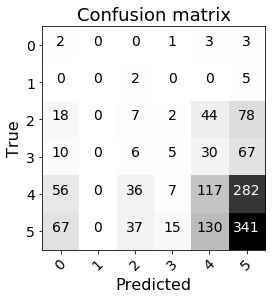

In [100]:
y_pred_raw = data.load('./y_pred_raw2')

print(len(y_pred_raw))

y_true = np.round(df2['Score'].iloc[:len(y_pred_raw)].values)

results2 = {}
results2['y_true'] = np.round(y_true).astype(int)
results2['y_pred'] = np.round(y_pred_raw).astype(int)

stats.print_all_stats(results2['y_true'], results2['y_pred'])
stats.plot_confusion_matrix(stats.cm(results2['y_true'], results2['y_pred']), classes=np.arange(6))

In [33]:
df3 = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter_wa.csv')

## What happens when I only use annotations?
feedback = df3['Feedback_Notes'].replace(np.nan, '')

In [ ]:
import spacy
nlp_en = spacy.load('en')

In [55]:
# annotations
extra_info = feedback.str.contains('extra_info').astype(np.int)
partially_missed_concept = feedback.str.contains('partially_missed_concept').astype(np.int)
missed_concept = np.logical_and(feedback.str.contains('missed_concept'), ~feedback.str.contains('partially_missed_concept')).astype(np.int)
misspelling = feedback.str.contains('misspelling').astype(np.int)
confusing_wording = feedback.str.contains('confusing_wording').astype(np.int)
lack_of_knowledge = feedback.str.contains('shows_lack_of_knowledge').astype(np.int)
not_enough_info = feedback.str.contains('not_enough_info').astype(np.int)

# features
features = pd.read_csv('../tmp/features/filtered_with_wa.csv', sep='~')
cv_ma1 = features['cv_ma1'].values

pipeline_fn = vsm.create_processing_fn(nlp_en, pp.EN_STOPS)
count_vec = f.create_count_vectorizer_fn(pipeline_fn, ngram_range=(1,3), stopwords=pp.EN_STOPS)

In [145]:
def cosine_coefficient(s1, s2):
    num = len(s1.intersection(s2))
    den = np.sqrt(len(s1)) * np.sqrt(len(s2))
    return num / (den + 1e-30)


def preprocess_fn(x):
    return [t.lemma_ for t in nlp_en(x) if not t.pos_ in ['PUNCT', 'DET']]

def preprocess_stops(x):
    return [t.lemma_ for t in nlp_en(x) if not t.pos_ in ['PUNCT', 'DET'] and not t.lemma_ in pp.EN_STOPS]

def preprocess_not(x):
    x  = nlp_en(x)
    tokens = []
    prefix = ''
    for t in x:
        if t.dep_ == 'neg':
            prefix = 'neg_'
            continue
        elif t.dep_ == 'punct':
            prefix = ''
            continue
        
        text = ''
        if t.pos_ == 'PRON':
            text = t.text.lower()
        else:
            text = t.lemma_
        fmt = '{}{}'.format(prefix, text)
        tokens.append(fmt)
    return tokens



In [ ]:
# Cosine Coefficient Feature
cos_coeff = []
for _index, row in df3.iterrows():
    ma = [t.lemma_ for t in nlp_en(row['MA']) if not t.pos_ in ['PUNCT', 'DET']] 
    sa = [t.lemma_ for t in nlp_en(row['SA']) if not t.pos_ in ['PUNCT', 'DET']]
    score = cosine_coefficient(set(ma), set(sa))
    cos_coeff.append(score)
cos_coeff = np.array(cos_coeff)

In [153]:
# Cosine Coefficient Feature
cos_coeff_na = []
for index, row in df3.iterrows():
    ma = preprocess_stops(row['NA']) 
    sa = preprocess_stops(row['SA'])
    score = cosine_coefficient(set(ma), set(sa))
    cos_coeff_na.append(score)
    if index % 300 == 0:
        print('[{}]: done.'.format(index))
cos_coeff_na = np.array(cos_coeff_na)

[0]: done.
[300]: done.
[600]: done.
[900]: done.
[1200]: done.
[1500]: done.
[1800]: done.
[2100]: done.
[2400]: done.
[2700]: done.


In [155]:
np.corrcoef([cos_coeff_na, df3['Class3_Score']])

array([[1.        , 0.14543873],
       [0.14543873, 1.        ]])

In [78]:
cos_coeff_not = []
for _index, row in df3.iterrows():
    ma = [t.lemma_ for t in nlp_en(row['MA']) if not t.pos_ in ['PUNCT', 'DET']] 
    sa = [t.lemma_ for t in nlp_en(row['SA']) if not t.pos_ in ['PUNCT', 'DET']]
    score = cosine_coefficient(set(ma), set(sa))
    cos_coeff_not.append(score)
cos_coeff_not = np.array(cos_coeff_not)

In [79]:
length_diff = []
for _index, row in df3.iterrows():
    ma = [t.lemma_ for t in nlp_en(row['MA']) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    sa = [t.lemma_ for t in nlp_en(row['SA']) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    x = len(ma) - len(sa)
    length_diff.append(x)
length_diff = np.array(length_diff)

In [111]:
norm_max = np.max(length_diff)
norm_min = np.min(length_diff)
length_diff_norm = (length_diff - norm_min) / (norm_max - norm_min)

In [117]:
vec_sim = []
for index, row in df3.iterrows():
    ma = pipeline_fn(row['MA'])
    sa = pipeline_fn(row['SA'])
    ma_t = nlp_en(' '.join(ma))
    sa_t = nlp_en(' '.join(sa))
    x = ma_t.similarity(sa_t)
    vec_sim.append(x)
vec_sim = np.array(vec_sim)

CV   COS_SIM  COS_SIM_NOT  LENGTH_DIFF   VEC_SIM  COS_SIM_NA
0  0.032791  0.213201     0.258199     0.641975  0.903453         0.0
1  0.000000  0.000000     0.000000     0.814815  0.543482         0.0

             precision    recall  f1-score   support

          0       0.85      0.79      0.82       321
          1       0.44      0.39      0.41       161
          2       0.61      0.73      0.67       237

avg / total       0.68      0.68      0.68       719

Pearson's R: 0.661285739671237
Cohen's Kappa: 0.5023981897729393
MAE: -0.09874826147426982
Accuracy: 68.01%
Precision: 68.34%
Recall: 68.01%
F1-Measure: 67.90%


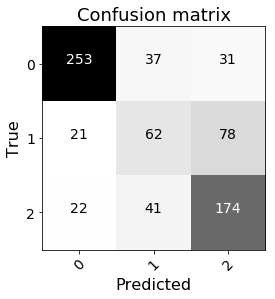

In [156]:
# clf = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,64), random_state=1)

y_true = np.round(df3['Score'].values)
df_features = pd.DataFrame(np.array([cv_ma1, cos_coeff, cos_coeff_not, length_diff_norm, vec_sim, cos_coeff_na]).T, 
                           columns=['CV', 'COS_SIM', 'COS_SIM_NOT', 'LENGTH_DIFF', 'VEC_SIM','COS_SIM_NA' ])
display(df_features.head(2))

x_train, x_test, y_train, y_test = train_test_split(df_features.as_matrix(), df3['Class3_Score'], test_size=0.25, random_state=22, stratify=df3['Class3_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

In [176]:
# How does it break down per problem?

def inspect_results(df, y_true, y_pred):
    idxs = np.unique(df['ID'].values)
    
    for idx in idxs:
        mask = df['ID'] == idx
        tmp_true = y_true[mask]
        tmp_pred = y_pred[mask]
        print('=============')
        print('ID: {}'.format(idx))
        stats.print_all_stats(tmp_true, tmp_pred)
        stats.plot_confusion_matrix(stats.cm(tmp_true, tmp_pred), classes=np.arange(3))
        print('=============')

y_pred = clf.predict(df_features.as_matrix())
#inspect_results(df3, df3['Class3_Score'], y_pred)

In [157]:
import libs.debug.tsne as tsne

pca = tsne.compute(df_features.as_matrix(), perplexity=50)

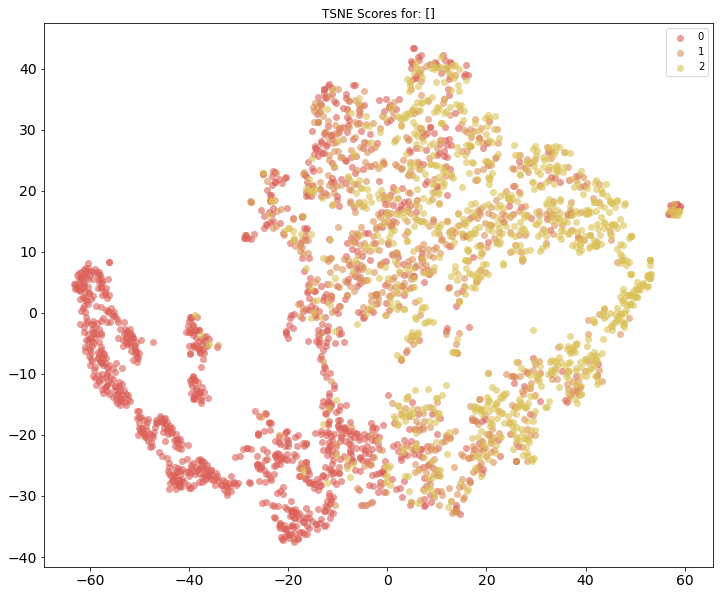

In [158]:
tsne.plot(pca, df3['Class3_Score'])

In [173]:
dfc = df_features.copy()
dfc['SA'] = df3['SA']
dfc['Score3'] = df3['Class3_Score'] 

# short wrong answers
#idxs = tsne.get_indexes(pca, [-95, -50], [10, 50])
#df3[idxs]

idxs = tsne.get_indexes(pca, [-20, 0], [-40, 30])
#dfc[idxs]

CV   COS_SIM  COS_SIM_NOT  LENGTH_DIFF   VEC_SIM  COS_SIM_NA  1.1  \
0  0.032791  0.213201     0.258199     0.641975  0.903453         0.0    1   
1  0.000000  0.000000     0.000000     0.814815  0.543482         0.0    1   

   1.2  1.3  1.5  ...   11.8  11.9  12.1  12.2  12.3  12.4  12.5  12.6  12.8  \
0    0    0    0  ...      0     0     0     0     0     0     0     0     0   
1    0    0    0  ...      0     0     0     0     0     0     0     0     0   

   12.9  
0     0  
1     0  

[2 rows x 76 columns]

             precision    recall  f1-score   support

          0       0.84      0.83      0.84       321
          1       0.55      0.47      0.51       161
          2       0.70      0.78      0.74       237

avg / total       0.73      0.74      0.73       719

Pearson's R: 0.7156591242380297
Cohen's Kappa: 0.5864588820071319
MAE: -0.04450625869262865
Accuracy: 73.57%
Precision: 73.16%
Recall: 73.57%
F1-Measure: 73.22%


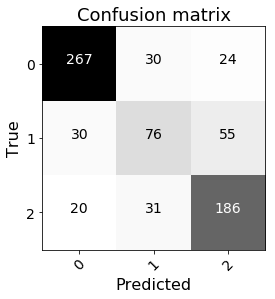

In [211]:
# clf = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,128,64), random_state=1)

question_id_features = pd.get_dummies(df3['ID'])

y_true = np.round(df3['Score'].values)
df_features2 = pd.DataFrame(np.array([cv_ma1, cos_coeff, cos_coeff_not, length_diff_norm, vec_sim, cos_coeff_na]).T, 
                           columns=['CV', 'COS_SIM', 'COS_SIM_NOT', 'LENGTH_DIFF', 'VEC_SIM','COS_SIM_NA' ])

df_features2 = df_features2.join(question_id_features)
display(df_features2.head(2))

x_train, x_test, y_train, y_test = train_test_split(df_features2.as_matrix(), df3['Class3_Score'], test_size=0.25, random_state=22, stratify=df3['Class3_Score'])

clf2.fit(x_train, y_train)

y_pred = clf2.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(3))

In [241]:
def test_student_response(clf, qid, model_answer, neg_answer, student_response, min_max=[0,1]):
    
    # feature 01
    f1 = count_vec(model_answer, student_response)
    
    # feature 02
    ma2 = preprocess_fn(model_answer)
    sa2 = preprocess_fn(student_response)
    f2 = cosine_coefficient(set(ma2), set(sa2))
    
    # feature 03 : cosine sim w/not
    ma3 = preprocess_not(model_answer)
    sa3 = preprocess_not(student_response)
    f3 = cosine_coefficient(set(ma3), set(sa3))
    
    # feature 04 : length difference
    ma = [t.lemma_ for t in nlp_en(model_answer) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    sa = [t.lemma_ for t in nlp_en(student_response) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    f4 = len(ma) - len(sa)
    f4 = (f4 - min_max[0]) / (min_max[1] - min_max[0])
    
    # feature 05 : vector similarity
    ma = pipeline_fn(row['MA'])
    sa = pipeline_fn(row['SA'])
    ma_t = nlp_en(' '.join(ma))
    sa_t = nlp_en(' '.join(sa))
    f5 = ma_t.similarity(sa_t)
    
    # feature 06
    na = preprocess_stops(neg_answer)
    sa6 = preprocess_stops(student_response)
    f6 = cosine_coefficient(set(na), set(sa2))
    
    # ID one-hot encoding feature
    cols = question_id_features.columns.tolist()
    id_one_hot = np.zeros(len(cols), dtype=np.int)
    id_one_hot[cols.index(qid)] = 1
    f7 = id_one_hot.tolist()
    
    vec = np.array([f1,f2,f3,f4,f5,f6] + f7)
    print(vec[:7])
    
    return clf.predict([vec])


idx = 100
qid = df3.iloc[idx]['ID']
ma = df3.iloc[idx]['MA']
prompt = df3.iloc[idx]['Prompt']
na = df3.iloc[idx]['NA']
print('[{}]: {}'.format(qid, prompt))
print(ma)
test_student_response(clf2, qid, ma, na, "abstraction and reusability", min_max=[norm_min, norm_max])

[1.3]:  What are the main advantages associated with object-oriented programming? 
 Abstraction and reusability. 
[1.         0.75       0.         0.75308642 0.67811815 0.
 0.        ]


array([2])

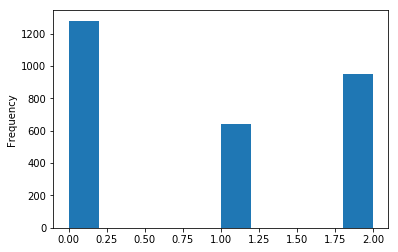

In [239]:
df3['Class3_Score'].plot(kind='hist')